In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from librosa import display
from scipy import signal
from scipy import fft
import glob
import pyaudio
import struct
import IPython.display as ipd

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#Data Exploration on two songs

In [2]:
#first load two musics into python and we can listen to the sample
ipd.Audio('/Users/changyuean/Python/Stanford/CS 229 Project/wav/2pac-trapped - 1.mp3')

In [3]:
ipd.Audio('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 1.mp3')

In [4]:
#we can see that the length of these two music pieces are different. 
#In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
#first load the mp3 file as data and frequency
#according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
#downsampled each sound file to 22,050 Hz and merge stereo to mono
#I will replicate the same process
data1, sampling_rate1 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/2pac-trapped - 1.mp3',
                                        sr=22050, mono=True, duration = 3)
data2, sampling_rate2 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 1.mp3',
                                        sr=22050, mono=True, duration = 3)

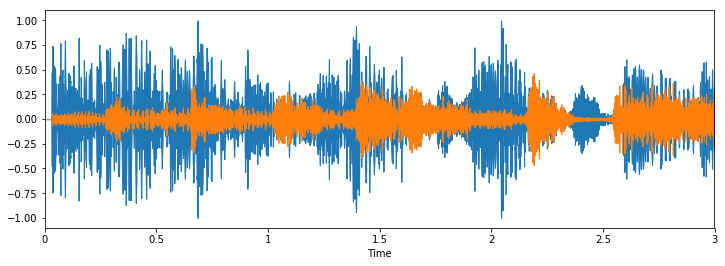

In [5]:
#visualize the wave plot
plt.figure(figsize=(12,4))
librosa.display.waveplot(data1, sr=sampling_rate1)
librosa.display.waveplot(data2, sr=sampling_rate2)

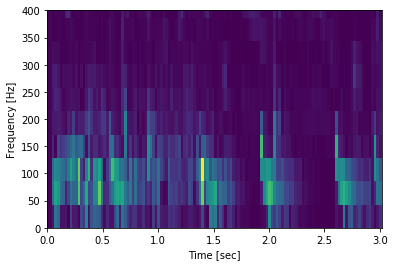

In [6]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=512, noverlap=0)
plt.ylim(0, 400) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

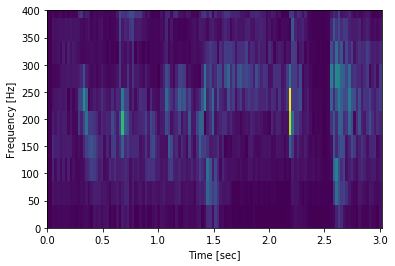

In [7]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies2, times2, spectrogram2 = signal.stft(data2,sampling_rate2, nperseg=512, noverlap=0)
plt.ylim(0, 400) 
plt.pcolormesh(times2, frequencies2, np.abs(spectrogram2))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [8]:
data1, sampling_rate1 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/5th_dimension-one_less_bell_to_answer - 4.mp3',
                                        sr=22050, mono=True, duration = 3)
data2, sampling_rate2 = librosa.core.load('/Users/changyuean/Python/Stanford/CS 229 Project/wav/10cc-for_you_and_i - 2.mp3',
                                        sr=22050, mono=True, duration = 3)

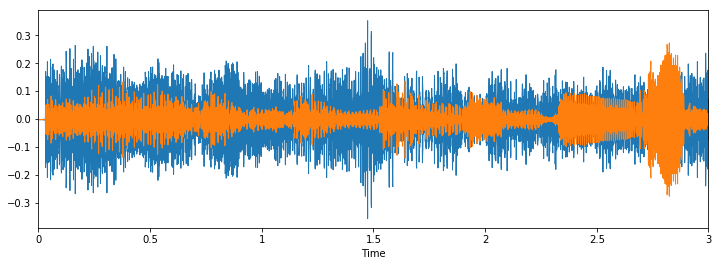

In [9]:
#visualize the wave plot
plt.figure(figsize=(12,4))
librosa.display.waveplot(data1, sr=sampling_rate1)
librosa.display.waveplot(data2, sr=sampling_rate2)

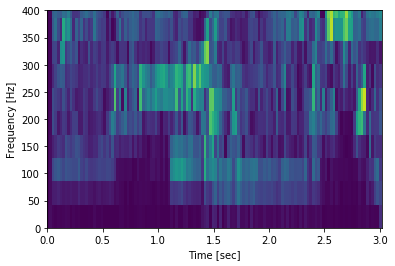

In [10]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies1, times1, spectrogram1 = signal.stft(data1,sampling_rate1, nperseg=512, noverlap=0)
plt.ylim(0, 400) 
plt.pcolormesh(times1, frequencies1, np.abs(spectrogram1))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

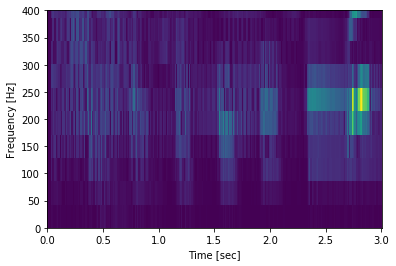

In [11]:
#according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
frequencies2, times2, spectrogram2 = signal.stft(data2,sampling_rate2, nperseg=512)
plt.ylim(0, 400) 
plt.pcolormesh(times2, frequencies2, np.abs(spectrogram2))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [12]:
#Emotion Labels for "2pac-trapped" and "10cc-for_you_and_i"
pac1 = pd.read_csv("/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/2pac-trapped.csv")
pac_song_emo1 = np.array(pac1["Song-Positive_Feelings"])
pac2 = pd.read_csv("/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/10cc-for_you_and_i.csv")
pac_song_emo2 = np.array(pac2["Song-Positive_Feelings"])

two_song_emo = np.append(pac_song_emo1,pac_song_emo2,axis =0)
two_song_emo = two_song_emo.reshape(1,2)
print(two_song_emo)

[[0 1]]


In [13]:
print(spectrogram1.shape)


(257, 131)


In [14]:
spect_subset1 = abs(spectrogram1[0:257,0:257])
spect_subset2 = abs(spectrogram1[0:257,0:257])

In [15]:
print(spect_subset1.shape)

(257, 131)


In [16]:
X1 = spect_subset1.reshape(-1,1)
X2 = spect_subset2.reshape(-1,1)

In [17]:
print(X1.shape)

(33667, 1)


In [18]:
X = np.append(X1,X2, axis=1)

In [19]:
print(X.shape)

(33667, 2)


#Generalize the Code to all data

In [20]:
# function to load label for a particular song
def load_label(label_dir, song_name):
    song_label = pd.read_csv(label_dir + song_name + ".csv")
    label = np.array(song_label["Song-Positive_Feelings"])
    return label

In [21]:
#function to read the mp3 data and pre-process it
def mp3_load_and_preprocess(data_dir, file_list, label_dir, segment_len =1024):
    
    songs = [line.rstrip('\n') for line in open(data_dir + file_list)]
    num_songs = len(songs)
    song_data_len = (int(segment_len/2) + 1)**2
    X = np.empty((song_data_len, num_songs))
    Y = np.empty((1, num_songs))
    #print(num_songs)
    #print(song_data_len)
    
    song_idx = 0
    for s in songs:
        #In order to train CNN on them, I need to trim all music to the same length (in this case 3 second length)
        #first load the mp3 file as data and frequency
        #according to the paper "TOWARDS TIME-VARYING MUSIC AUTO-TAGGING BASED ON CAL500 EXPANSION", the authors 
        #downsampled each sound file to 22,050 Hz and merge stereo to mono
        #I will replicate the same process
        song_data, sampling_rate = librosa.core.load(data_dir + s, sr=22050, mono=True, duration =3 )
        
        #according to the paper "CNN BASED MUSIC EMOTION CLASSIFICATION", the authors transformed the music into spectrogram
        frequencies, times, spectrogram = signal.stft(song_data,sampling_rate, nperseg=segment_len)
        # make the spectrogram a K x K matrix, with K = segment_len/2
        spect_dim = int(segment_len/2) + 1
        spect_subset = abs(spectrogram[0:spect_dim,0:spect_dim])
        spect_reshaped = spect_subset.reshape(-1,)
        
        X[:,song_idx] = spect_reshaped
        
        #get label for this song
        song_name_parts = s.split(" ") # split name based on spaces
        song_base_name = song_name_parts[0]
        label = load_label(label_dir, song_base_name)
        
        # add label to Y
        Y[:,song_idx] = label
        
        song_idx += 1
        
    return X, Y


In [22]:
# load and pre-process data
data_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/wav/"
file_list = "mp3.txt"
label_directory = "/Users/changyuean/Python/Stanford/CS 229 Project/SongLabelHard/"

X, Y = mp3_load_and_preprocess(data_directory, file_list, label_directory, segment_len=512)
print(X.shape)
print(Y.shape)
print(Y)

(66049, 3223)
(1, 3223)
[[1. 1. 1. ... 0. 0. 0.]]


In [23]:
#split the data to train and test set
def data_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.1, random_state=0)
    X_train = X_train.T
    X_test = X_test.T
    Y_train = Y_train.T
    Y_test = Y_test.T
    return X_train, X_test, Y_train, Y_test

In [24]:
def initialize(X):
    W = np.random.randn(X.shape[0],1)*np.sqrt(1/X.shape[0])
    b = np.zeros(1)
    return W, b

In [25]:
def sigmoid(X, W, b):
    W, b = initialize(X)
    Z = np.dot(W.T,X)+b
    A = 1/ (1+np.exp(-Z))
    return A

In [26]:
def cost_function(X, Y, W, b):
    m = X.shape[0]
    A = sigmoid(X, W, b)
    cost = (-1/m)*np.sum(np.dot(Y,np.log(A).T)+np.dot(1-Y,np.log(1-A).T))
    dW = np.dot(X,(Y-A).T)
    db = np.sum(Y-A)
    grads = {"dW":dW, 
             "db":db}
    return cost, grads

In [27]:
def optimize(W, b, X, Y, learning_rate, beta):
    cost, grads = cost_function(X, Y, W, b)
    #update the W and bgradient descent and momentum
    #calculate the velocity using momentum
    v = grads["dW"]
    W = W - learning_rate*v
    b = b - learning_rate*grads["db"]
    
    cost_list = []
    cost_list.append(cost)
    params = {}
    prev_cost = None
    threshold = 1e-15
    iteration = 1
    while ((prev_cost is None or (abs(cost - prev_cost)>threshold)) and iteration<800):
        prev_cost = cost
        cost, grads = cost_function(X, Y, W, b)
        v = beta*v + (1-beta)*grads["dW"]
        learning_rate = learning_rate/iteration
        W = W - learning_rate*v
        b = b - learning_rate*grads["db"]
        cost_list.append(cost)
        iteration = iteration+1
        if iteration%10==0:
            print("Cost after iteration %i: %f" %(iteration, cost))
    
    params["W"] = W
    params["b"] = b
    params["number of iterations"] = iteration
    
    return params, cost_list
    

In [28]:
def prediction(params, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigmoid(X, params["W"], params["b"])
    
    for i in range(A. shape[1]):
        if A[0,i]>0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [29]:
def confusion_matrix(Y_pred, Y_test):
    
    conf_matrix = {}
    TPcount = 0
    FPcount = 0
    FNcount = 0
    TNcount = 0
    
    for i in range(Y_test.shape[1]):
        if Y_pred[0,i]==1 and Y_test[0,i]==1:
            # true positive
            TPcount+=1
        elif Y_pred[0,i]==0 and Y_test[0,i]==1:
            FNcount+=1
        elif Y_pred[0,i]==1 and Y_test[0,i]==0:
            FPcount+=1
        else:
            TNcount+=1
    
    conf_matrix["True Positive"] = TPcount
    conf_matrix["False Positive"] = FPcount
    conf_matrix["False Negative"] = FNcount
    conf_matrix["True Negative"] = TNcount
    
    return conf_matrix
            

In [30]:
#define a main function to run the code
def main (X, Y, learning_rate = 0.001, beta=0.9):
    X_train, X_test, Y_train, Y_test = data_split(X, Y)
    W, b = initialize(X_train)
    #cost, grads = cost_function(X, Y, W, b, regularization)
    params, cost_list = optimize(W, b, X_train, Y_train, learning_rate, beta)
    
    Y_pred = prediction(params, X_test)
    
    c_matrix = confusion_matrix(Y_pred, Y_test)
    
    Accuracy = (c_matrix["True Positive"]+c_matrix["True Negative"])/Y_test.shape[1]
    print("Confusion Matrix:", c_matrix)
    print("Accuracy:", Accuracy)
    
    return params, cost_list, c_matrix

In [ ]:
params, cost_list,c_matrix = main (X, Y, learning_rate = 0.2, beta=0.9)

In [ ]:
plt.plot(cost_list)
plt.xlabel("iterations")
plt.ylabel("cost")

In [ ]:
print(params)

In [ ]:
print(X.shape)

#Apply Support Vector Machine with the music data

In [41]:
from sklearn.svm import SVC

In [94]:
model = SVC(kernel='rbf',degree = 10, C=10, probability=True)

In [95]:
#reshape Y from (1,3223) to (3223,)

Y_res = Y.reshape(3223,)
Y_test = Y_res[1:100]
Y_res.shape
X_test = X[:,1:100]
Y_test.shape

(99,)

In [96]:
model.fit(X_test.T, Y_test)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=10, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
pred = model.predict(X_test.T)

In [98]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(99):

    if pred[i]==1 and Y_test[i]==1:
        TP +=1
    elif pred[i]==0 and Y_test[i]==1:
        FN +=1
    elif pred[i]==1 and Y_test[i]==0:
        FP +=1
    else:
        TN +=1
        
print("Accuracy:", (TN+TP)/99)

Accuracy: 0.6262626262626263
